# XGBoost — Baseline Prédiction autorégressiive (fenêtres glissantes)

## Objectif
Ce notebook implémente un **XGBoost** comme modèle de référence (baseline) pour la prédiction
autorégressiive de `Total_reservations`.

## Approche — fenêtres glissantes aplaties
XGBoost est un modèle **non-séquentiel** : on transforme la série temporelle en
données tabulaires en **aplatissant** la fenêtre glissante :

```
Fenêtre (WINDOW × n_features)  →  aplatissement  →  vecteur de WINDOW*n_features valeurs
XGBRegressor → prédiction scalaire Total_reservations
```

**Pas de normalisation nécessaire** : XGBoost est invariant aux transformations monotones.

## Stratégie autorégressiive
Identique aux modèles DL : le `Total_reservations` prédit remplace la valeur réelle
dans la fenêtre à chaque étape. Les features exogènes sont connues à l'avance.

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |

## Avantages du XGBoost comme baseline
- Pas d'entraînement itératif → rapide et reproductible
- Interprétable via l'**importance des features**
- Robuste aux outliers et aux valeurs manquantes
- Donne une borne inférieure de performance attendue des modèles DL

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [1]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH   = '../data/df_venues_final.csv'
TARGET_COL  = 'GLOBAL'
MODEL_NAME  = 'XGBoost'

WINDOW      = 5      # jours de contexte (fenêtre glissante aplatie)
N_TEST      = 5      # jours de test = dernière semaine

# Hyperparamètres XGBoost
N_ESTIMATORS     = 300
MAX_DEPTH        = 4
LEARNING_RATE    = 0.05
SUBSAMPLE        = 0.8
COLSAMPLE_BYTREE = 0.8
MIN_CHILD_WEIGHT = 2
REG_ALPHA        = 0.1    # régularisation L1
REG_LAMBDA       = 1.0    # régularisation L2
RANDOM_STATE     = 42
N_JOBS           = -1     # utiliser tous les cores disponibles

FEATURES = [
    'GLOBAL',               # idx 0 — feedback autorégressif
    'Total_reservations', 'Temp', 'pluie', 'autre',
    'Greve_nationale', 'prof_nationale',
    'jour_ferie.', 'pont.conge.', 'holiday',
    'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi',
]
TARGET_IDX = 0

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = f'../img/{MODEL_NAME.lower()}_results.png'

## 2 — Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

warnings.filterwarnings('ignore')
np.random.seed(RANDOM_STATE)

print('XGBoost et dépendances importés ✓')

XGBoost et dépendances importés ✓


## 3 — Chargement et tri chronologique

Même pipeline de préparation que les modèles DL pour une comparaison équitable.

In [3]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Shape : {df.shape}')
_last = df.iloc[-N_TEST:]
TEST_LABEL = f"S{int(_last.iloc[0]['Semaine'])}/{int(_last.iloc[0]['Annee'])}"
print(f'Période : {df["Annee"].min()}/S{df["Semaine"].min()} → {df["Annee"].max()}/S{df["Semaine"].max()}')
print(f'\n--- Dernière semaine de test ({TEST_LABEL}) ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

Shape : (250, 18)
Période : 2022/S1 → 2023/S51

--- Dernière semaine de test (S39/2023) ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Construction des fenêtres glissantes (format tabulaire)

**Différence clé vs DL :** au lieu de conserver la structure `(N, WINDOW, n_features)`,
on **aplatit** chaque fenêtre en un vecteur `(N, WINDOW × n_features)`.

```
Fenêtre [jour_0, jour_1, ..., jour_{W-1}]  (W × F dimensions)
         ↓  aplatissement (flatten)
Vecteur  [f00, f01, ..., f0F, f10, f11, ..., f_{W-1,F}]  (W×F dimensions)
```

Les noms de features incluent le décalage temporel (`_d0`, `_d1`, ...) pour interpréter
l'importance XGBoost.

In [4]:
data = df[FEATURES].values.astype(float)  # pas de normalisation pour XGBoost

n_train = len(df) - N_TEST
train_data = data[:n_train]
test_data  = data[n_train:]

def make_flat_sequences(X, window):
    """Construit des fenêtres glissantes aplaties pour XGBoost (format tabulaire)."""
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i].flatten())  # aplatissement
        ys.append(X[i, TARGET_IDX])
    return np.array(Xs, dtype=float), np.array(ys, dtype=float)

X_train, y_train = make_flat_sequences(train_data, WINDOW)

# Noms de features pour l'importance
feature_names = [f'{col}_d{k}' for k in range(WINDOW) for col in FEATURES]

print(f'Échantillons train : {X_train.shape[0]}  |  Features aplaties : {X_train.shape[1]}')
print(f'Dernière semaine test : {TEST_LABEL}')
print(f'\nFenêtre initiale de prédiction (jours {n_train - WINDOW}–{n_train - 1}) :')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].iloc[n_train - WINDOW:n_train].to_string())

Échantillons train : 240  |  Features aplaties : 75
Dernière semaine test : S39/2023

Fenêtre initiale de prédiction (jours 240–244) :
     Annee  Semaine  day_num  GLOBAL
240   2023       38        0     676
241   2023       38        1     764
242   2023       38        2     714
243   2023       38        3     677
244   2023       38        4     558


## 5 — Entraînement XGBoost

Le `XGBRegressor` est entraîné en une seule passe (pas d'entraînement itératif par epoch).
La métrique d'entraînement est calculée sur l'ensemble du train pour évaluer l'ajustement.

In [5]:
model = XGBRegressor(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE,
    subsample=SUBSAMPLE,
    colsample_bytree=COLSAMPLE_BYTREE,
    min_child_weight=MIN_CHILD_WEIGHT,
    reg_alpha=REG_ALPHA,
    reg_lambda=REG_LAMBDA,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbosity=0,
)

model.fit(X_train, y_train)

# Métriques sur le train (vérification d'ajustement)
train_pred = model.predict(X_train)
train_mae  = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
train_r2   = r2_score(y_train, train_pred)

print(f'Train — MAE : {train_mae:.1f}  |  MAPE : {train_mape:.1f}%  |  RMSE : {train_rmse:.1f}  |  R² : {train_r2:.4f}')
print(f'\nNombre d\'estimateurs : {N_ESTIMATORS}  |  Max depth : {MAX_DEPTH}  |  LR : {LEARNING_RATE}')

Train — MAE : 7.6  |  MAPE : 3.2%  |  RMSE : 10.1  |  R² : 0.9957

Nombre d'estimateurs : 300  |  Max depth : 4  |  LR : 0.05


## 6 — Prédiction autorégressiive (fenêtre glissante)

**Pour chaque jour `t` de la semaine cible :**

1. Aplatir la fenêtre courante `(WINDOW × n_features)` → vecteur
2. Passer dans XGBoost → `ŷ_t` (valeur brute, pas normalisée)
3. Créer le vecteur du jour `t` : features exogènes réelles + `Total_reservations = ŷ_t`
4. Glisser la fenêtre

**Note :** contrairement aux modèles DL, pas besoin de dénormalisation.

In [6]:
# Fenêtre initiale : WINDOW jours réels avant la semaine de test
window_rows = [data[n_train - WINDOW + k].copy() for k in range(WINDOW)]

preds_real = []
real_real  = df[TARGET_COL].values[-N_TEST:]

print('=== Prédiction autorégressiive (fenêtre glissante) ===')
print(f"{'Étape':<6} {'Jour':<10} {'Prédit':>8} {'Réel':>8} {'Err abs':>9} {'Err %':>8}")
print('-' * 56)

for step in range(N_TEST):
    # Aplatissement de la fenêtre
    x_input = np.array(window_rows, dtype=float).flatten().reshape(1, -1)
    pred    = float(model.predict(x_input)[0])
    actual  = float(real_real[step])
    preds_real.append(pred)

    err_abs = abs(actual - pred)
    err_pct = 100 * err_abs / actual
    print(f'{step+1:<6} {DAY_LABELS[step]:<10} {pred:>8.0f} {actual:>8.0f} {err_abs:>9.1f} {err_pct:>7.1f}%')

    # Nouveau jour : features exogènes réelles + Total_reservations prédit
    new_row             = test_data[step].copy()
    new_row[TARGET_IDX] = pred
    window_rows.pop(0)
    window_rows.append(new_row)

preds_real = np.array(preds_real)

=== Prédiction autorégressiive (fenêtre glissante) ===
Étape  Jour         Prédit     Réel   Err abs    Err %
--------------------------------------------------------
1      Lundi           674      624      49.8     8.0%
2      Mardi           756      713      43.0     6.0%
3      Mercredi        709      623      86.0    13.8%
4      Jeudi           675      659      16.3     2.5%
5      Vendredi        506      408      98.3    24.1%


## 7 — Métriques

In [7]:
mae  = mean_absolute_error(real_real, preds_real)
mape = mean_absolute_percentage_error(real_real, preds_real) * 100
rmse = np.sqrt(np.mean((real_real - preds_real) ** 2))
r2   = r2_score(real_real, preds_real)

print(f'╔{"═" * 50}╗')
print(f'║  Métriques {MODEL_NAME} — {TEST_LABEL:<{37}}║')
print(f'╠{"═" * 50}╣')
print(f'║  MAE   (Erreur absolue moyenne)  : {mae:>7.1f} réserv. ║')
print(f'║  MAPE  (Erreur % moyenne)        : {mape:>6.2f}%          ║')
print(f'║  RMSE  (Racine erreur quadrat.)  : {rmse:>7.1f} réserv. ║')
print(f'║  R²    (Coefficient det.)        : {r2:>7.4f}           ║')
print(f'╚{"═" * 50}╝')

╔══════════════════════════════════════════════════╗
║  Métriques XGBoost — S39/2023                             ║
╠══════════════════════════════════════════════════╣
║  MAE   (Erreur absolue moyenne)  :    58.7 réserv. ║
║  MAPE  (Erreur % moyenne)        :  10.88%          ║
║  RMSE  (Racine erreur quadrat.)  :    65.8 réserv. ║
║  R²    (Coefficient det.)        :  0.5997           ║
╚══════════════════════════════════════════════════╝


## 8 — Visualisations

Trois graphiques standardisés :
1. **Importance des features** (top 15) — remplace la courbe d'apprentissage car XGBoost
   est entraîné en une passe (pas d'itérations par epoch).
   L'importance est mesurée par le **gain moyen** : contribution de chaque feature
   à la réduction de la loss lors des splits.
2. **Série complète + prédiction**
3. **Barres côte à côte jour par jour**

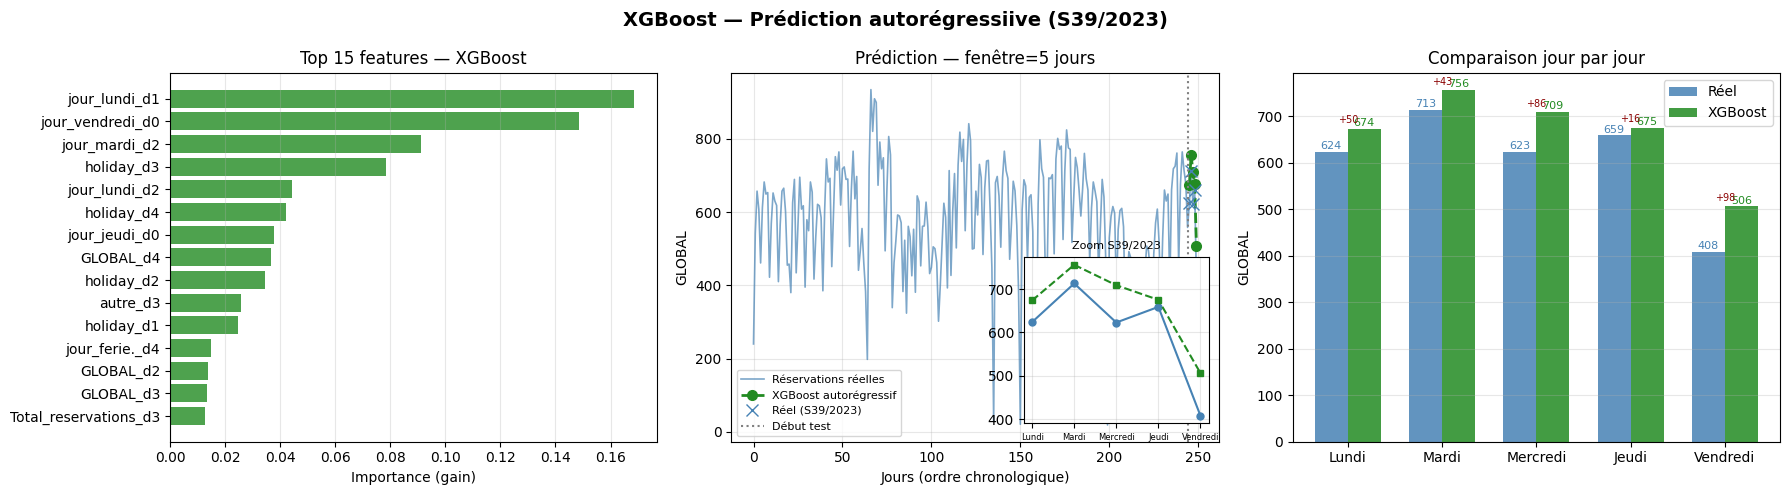

Figure sauvegardée → ../img/xgboost_results.png


In [8]:
all_real     = df[TARGET_COL].values
test_indices = list(range(len(all_real) - N_TEST, len(all_real)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'{MODEL_NAME} — Prédiction autorégressiive ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Importance des features (top 15) ─────────────────────────────────
ax = axes[0]
importances = model.feature_importances_
top_n = 15
sorted_idx = np.argsort(importances)[::-1][:top_n]
top_names  = [feature_names[i] for i in sorted_idx]
top_vals   = importances[sorted_idx]

ax.barh(top_names[::-1], top_vals[::-1], color='forestgreen', alpha=0.8)
ax.set_xlabel('Importance (gain)')
ax.set_title(f'Top {top_n} features — {MODEL_NAME}')
ax.grid(axis='x', alpha=0.3)

# ── 2 : Série complète + prédiction ─────────────────────────────────────
ax = axes[1]
ax.plot(range(len(all_real)), all_real,
        label='Réservations réelles', color='steelblue', alpha=0.7, lw=1.2)
ax.plot(test_indices, preds_real,
        label=f'{MODEL_NAME} autorégressif', color='forestgreen',
        ls='--', marker='o', ms=7, lw=2)
ax.plot(test_indices, real_real,
        color='steelblue', marker='x', ms=9, ls='None', label=f'Réel ({TEST_LABEL})')
ax.axvline(x=test_indices[0] - 0.5, color='gray', ls=':', lw=1.5, label='Début test')
ax.set_xlabel('Jours (ordre chronologique)')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Prédiction — fenêtre={WINDOW} jours')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

axins = ax.inset_axes([0.60, 0.05, 0.38, 0.45])
axins.plot(DAY_LABELS, real_real, 'o-', color='steelblue', ms=5)
axins.plot(DAY_LABELS, preds_real, 's--', color='forestgreen', ms=5)
axins.set_title(f'Zoom {TEST_LABEL}', fontsize=8)
axins.tick_params(axis='x', labelsize=6)
axins.grid(alpha=0.3)

# ── 3 : Barres côte à côte ───────────────────────────────────────────────
ax    = axes[2]
x     = np.arange(N_TEST)
width = 0.35
b_r   = ax.bar(x - width/2, real_real,  width, label='Réel',       color='steelblue',  alpha=0.85)
b_p   = ax.bar(x + width/2, preds_real, width, label=MODEL_NAME,   color='forestgreen', alpha=0.85)
for bar, val in zip(b_r, real_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='steelblue')
for bar, val in zip(b_p, preds_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='forestgreen')
ax.set_xticks(x)
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title('Comparaison jour par jour')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i in range(N_TEST):
    err = preds_real[i] - real_real[i]
    ax.text(i, max(real_real[i], preds_real[i]) + 12,
            f'{err:+.0f}', ha='center', fontsize=7, color='darkred')

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 9 — Trace de la fenêtre glissante

In [9]:
print(f'=== Trace de la fenêtre glissante — {MODEL_NAME} ===')
print(f"{'Étape':<7} {'Jour':<12} {'Réel':>6} {'Prédit':>7} {'Err abs':>8} {'Err %':>7}   Rôle")
print('-' * 75)
for i, d in enumerate(DAY_LABELS):
    err_abs = abs(preds_real[i] - real_real[i])
    err_pct = 100 * err_abs / real_real[i]
    role = '← injecté dans la fenêtre suivante' if i < N_TEST - 1 else '← prédiction finale'
    print(f'  {i}      {d:<12} {real_real[i]:>6.0f} {preds_real[i]:>7.0f} {err_abs:>8.1f} {err_pct:>6.1f}%   {role}')

print(f'\nRésumé : MAE={mae:.1f} | MAPE={mape:.2f}% | RMSE={rmse:.1f} | R²={r2:.4f}')

=== Trace de la fenêtre glissante — XGBoost ===
Étape   Jour           Réel  Prédit  Err abs   Err %   Rôle
---------------------------------------------------------------------------
  0      Lundi           624     674     49.8    8.0%   ← injecté dans la fenêtre suivante
  1      Mardi           713     756     43.0    6.0%   ← injecté dans la fenêtre suivante
  2      Mercredi        623     709     86.0   13.8%   ← injecté dans la fenêtre suivante
  3      Jeudi           659     675     16.3    2.5%   ← injecté dans la fenêtre suivante
  4      Vendredi        408     506     98.3   24.1%   ← prédiction finale

Résumé : MAE=58.7 | MAPE=10.88% | RMSE=65.8 | R²=0.5997
